<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

По условию задачи известно, что из "Бета-банка каждый месяц понемногу стали уходить клиенты. По расчетам маркетологов, сохранять текущих клиентов дешевле, чем привлекать новых. В нашем распоряжении исторические данные о поведении клиентов "Бета-банка" и расторжении договоров. На основании этих данных нужно построить модель, которая будет прогнозировать, уйдет ли клиент из банка в ближайшее время или нет. 

В ячейку ниже будем импортировать все необходимые для решения задачи библиотеки

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Откроем файл и посмотрим, что он из себя представляет

In [80]:
data = pd.read_csv('/datasets/Churn.csv')

In [81]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим данные на пропуски

In [82]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Пропуски есть в одном столбце - Tenure. Заменим их на -1, чтобы избежать ошибок при вычислениях

In [83]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [84]:
data['Tenure'] = data['Tenure'].fillna(-1)

In [85]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., -1.])

В целом оставшиеся нулевые значения могут показывать, что клиент появился у банка меньше года назад.

In [86]:
data['Tenure'].value_counts()

 1.0     952
 2.0     950
 8.0     933
 3.0     928
 5.0     927
 7.0     925
-1.0     909
 4.0     885
 9.0     882
 6.0     881
 10.0    446
 0.0     382
Name: Tenure, dtype: int64

Удалим из таблицы три столбца, которые не несут полезной информации для обучающих моделей, так как ничего не говорят о поведении клиента

In [87]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [88]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


После удаления столбца 'Surname' у нас осталось два столбца с нечисловыми значениями - 'Geography' и 'Gender'. Переведем их в количественные методом OHE, а также уберем первые стоблцы в обработанных данных, чтобы избежать дамми-ошибок.

Разделим таблицу на признаки и целевой признак согласно условию задачи.

In [90]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

In [91]:
print(features.shape)
print(target.shape)

(10000, 10)
(10000,)


Разделим данные на три выборки - обучающую, валидационную, тестовую - в соотношении 3:1:1.

In [92]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)

In [93]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                            test_size=0.5, 
                                                                           random_state=12345)

In [94]:
print('Размер обучающей выборки:')
print(features_train.shape)
print(target_train.shape)
print()
print('Размер валидационной выборки:')
print(features_valid.shape)
print(target_valid.shape)
print()
print('Размер тестовой выборки:')
print(features_test.shape)
print(target_test.shape)

Размер обучающей выборки:
(6000, 10)
(6000,)

Размер валидационной выборки:
(2000, 10)
(2000,)

Размер тестовой выборки:
(2000, 10)
(2000,)


In [95]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [96]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0,1,1
3411,711,37,8.0,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1,0,1
1247,512,24,6.0,0.00,2,1,0,37654.31,0,0,1
3716,665,27,2.0,147435.96,1,0,0,187508.06,1,0,0


Приведем признаки в одному масштабу.

In [97]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [98]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [99]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

Посмотрим на тренировочной выборке, что получилось.

In [100]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.083651,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.083651,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.452862,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.469046,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.760164,1.140475,-0.891560,0,0,1.524268,1,0,0


## Исследование задачи

Мы решаем задачу классификации, когда нужно угадать один из двух ответов - 0 или 1. Для этого у нас есть три модели обучения со своими преимуществами и недостатками. Начнем с дерева решений. Зададим параметр глубины дерева 5. Если глубина меньше 4, то модель недообучается, если выше - переобучается. Наибольшее значение точности мы получили при значении 5.

In [101]:
DTC_model = None
DTC_result = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, criterion='gini', max_depth=depth)
    model.fit(features_train, target_train)
    DTC_predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, DTC_predictions)
    if result > DTC_result:
        DTC_model = model
        DTC_result = result

Рассчитаем также остальные метрики: полноту, точность и f1-меру. Целевое значение f1-меры для нас 0.59. Модель его не достигает.

In [102]:
DTC_model

DecisionTreeClassifier(max_depth=6, random_state=12345)

In [103]:
DTC_result = accuracy_score(target_valid, DTC_predictions)
DTC_recall = recall_score(target_valid, DTC_predictions)
DTC_precision = precision_score(target_valid, DTC_predictions)
DTC_f1 = f1_score(target_valid, DTC_predictions)

In [104]:
print(DTC_result)
print(DTC_recall)
print(DTC_precision)
print(DTC_f1)

0.8375
0.4473684210526316
0.6654804270462633
0.5350500715307582


Случайный лес дает самое высокое качество предсказаний при более медленной работе.

In [105]:
RFC_model = RandomForestClassifier(random_state=12345, n_estimators=100)
RFC_model.fit(features_train, target_train)
RFC_predictions = RFC_model.predict(features_valid)

In [106]:
RFC_result = accuracy_score(target_valid, RFC_predictions)
RFC_recall = recall_score(target_valid, RFC_predictions)
RFC_precision = precision_score(target_valid, RFC_predictions)
RFC_f1 = f1_score(target_valid, RFC_predictions)

В нашем случае при количестве деревьев 100 мы получили качество выше, чем в модели решающего дерева. Метрика f1 оказалась равна 0.59.

In [107]:
print(RFC_result)
print(RFC_recall)
print(RFC_precision)
print(RFC_f1)

0.8605
0.48086124401913877
0.7642585551330798
0.5903083700440529


Проверка на тестовой выборке уже не дает нужный результат.

In [108]:
RFC_pred_test = RFC_model.predict(features_test)
f1_score(target_test, RFC_pred_test)

0.5317220543806647

Рассмотрим еще одну модель - логистическая регрессия. У нее малая вероятность переобучения из-за небольшого количества параметров, но метрики оказываются самыми слабыми.

In [109]:
LR_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=200)
LR_model.fit(features_train, target_train)
LR_predictions = LR_model.predict(features_valid)

In [110]:
LR_result = accuracy_score(target_valid, LR_predictions)
LR_recall = recall_score(target_valid, LR_predictions)
LR_precision = precision_score(target_valid, LR_predictions)
LR_f1 = f1_score(target_valid, LR_predictions)

In [111]:
print(LR_result)
print(LR_recall)
print(LR_precision)
print(LR_f1)

0.8025
0.23684210526315788
0.5657142857142857
0.33389544688026984


Проверим модель на адекватность. Посмотрим в целом на соотношение ответов 0 и 1 в наших данных. Как видно, количество ответов 0 существенно превышает ответы 1.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

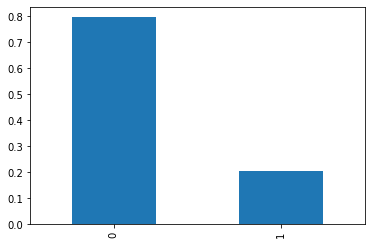

In [112]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Посмотрим на то, какие ответы склонны предсказывать наши модели. Ближе всего к реальному значению оказывается модель случайного леса.

In [113]:
DTC_predictions = pd.Series(DTC_model.predict(features_valid))
class_frequency = DTC_predictions.value_counts(normalize=True)
class_frequency

0    0.879
1    0.121
dtype: float64

In [114]:
RFC_predictions = pd.Series(RFC_model.predict(features_valid))
class_frequency = RFC_predictions.value_counts(normalize=True)
class_frequency

0    0.8685
1    0.1315
dtype: float64

In [115]:
LR_predictions = pd.Series(LR_model.predict(features_valid))
class_frequency = LR_predictions.value_counts(normalize=True)
class_frequency

0    0.9125
1    0.0875
dtype: float64

Построим матрицы ошибок для каждой из наших моделей.

In [116]:
confusion_matrix(target_valid, DTC_predictions)

array([[1528,   54],
       [ 230,  188]])

In [117]:
confusion_matrix(target_valid, RFC_predictions)

array([[1520,   62],
       [ 217,  201]])

In [118]:
confusion_matrix(target_valid, LR_predictions)

array([[1506,   76],
       [ 319,   99]])

## Борьба с дисбалансом

Соотношение ответов далеко от 1:1. Попробуем исправить этот дисбаланс в данных. Сбалансируем данные в модели решающего дерева, чтобы редкие ответы получили больший вес.

In [119]:
DTC_model_weighted = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
DTC_model_weighted.fit(features_train, target_train)
DTC_weighted_pred = DTC_model_weighted.predict(features_valid)

In [120]:
DTC_model_weighted_accuracy = accuracy_score(target_valid, DTC_weighted_pred)
DTC_model_weighted_recall = recall_score(target_valid, DTC_weighted_pred)
DTC_model_weighted_precision = precision_score(target_valid, DTC_weighted_pred)
DTC_model_weighted_f1 = f1_score(target_valid, DTC_weighted_pred)

Это позволило нам улучшить метрики модели и получить целевое значение f1-меры.

In [121]:
print(DTC_model_weighted_accuracy)
print(DTC_model_weighted_recall)
print(DTC_model_weighted_precision)
print(DTC_model_weighted_f1)

0.8105
0.6698564593301436
0.5374280230326296
0.5963791267305644


Также увеличим количество данных - сделаем редкий класс не таким редким техникой upsampling.

In [122]:
def upsample(features, target, repeat):
    # разделим выборку на отрицательные и положительные ответы
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # скопируем несколько раз положительные ответы
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем данные, чтобы одинаковые вопросы не шли друг за другом
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [123]:
# создадим новую обучающую выборку
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

In [124]:
# на новой обучающей выборке обучим модель решающего дерева
DTC_model_up = DTC_model.fit(features_upsampled, target_upsampled)
DTC_pred_up = DTC_model_up.predict(features_valid)

In [125]:
# посчитаем метрики
DTC_model_up_accuracy = accuracy_score(target_valid, DTC_pred_up)
DTC_model_up_recall = recall_score(target_valid, DTC_pred_up)
DTC_model_up_precision = precision_score(target_valid, DTC_pred_up)
DTC_model_up_f1 = f1_score(target_valid, DTC_pred_up)

Увеличение выборки на решающем дереве не помогло улучшить качество модели и даже снизило его.

In [126]:
print(DTC_model_up_accuracy)
print(DTC_model_up_recall)
print(DTC_model_up_precision)
print(DTC_model_up_f1)

0.7335
0.7464114832535885
0.42219215155615697
0.5393258426966292


In [127]:
# обучим на увеличенной выборке модель случайного леса
RFC_model_up = RFC_model.fit(features_upsampled, target_upsampled)
RFC_pred_up = RFC_model_up.predict(features_valid)

In [128]:
# посчитаем метрики
RFC_model_up_accuracy = accuracy_score(target_valid, RFC_pred_up)
RFC_model_up_recall = recall_score(target_valid, RFC_pred_up)
RFC_model_up_precision = precision_score(target_valid, RFC_pred_up)
RFC_model_up_f1 = f1_score(target_valid, RFC_pred_up)

Точность модели случайного леса на увеличенной выборке все еще остается на требуемом уровне.

In [129]:
print(RFC_model_up_accuracy)
print(RFC_model_up_recall)
print(RFC_model_up_precision)
print(RFC_model_up_f1)

0.8475
0.5406698564593302
0.6666666666666666
0.5970937912813739


Еще один способ борьбы с дисбалансом - уменьшение выборки, когда частые ответы становятся не такими частыми.

In [130]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # случайным образом отбросим часть отрицательных ответов
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешаем данные
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [131]:
# создадим новую обучающую выборку
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [132]:
# обучим на новой выборке модель дерева решений
DTC_model_down = DTC_model.fit(features_downsampled, target_downsampled)
DTC_pred_down = DTC_model_down.predict(features_valid)

In [133]:
DTC_model_down_accuracy = accuracy_score(target_valid, DTC_pred_down)
DTC_model_down_recall = recall_score(target_valid, DTC_pred_down)
DTC_model_down_precision = precision_score(target_valid, DTC_pred_down)
DTC_model_down_f1 = f1_score(target_valid, DTC_pred_down)

Модель дерева решений снова потеряла в качестве уже на уменьшении выборки.

In [134]:
print(DTC_model_down_accuracy)
print(DTC_model_down_recall)
print(DTC_model_down_precision)
print(DTC_model_down_f1)

0.8215
0.5311004784688995
0.5796344647519582
0.5543071161048689


In [135]:
# обучим на новой выборке модель случайного леса
RFC_model_down = RFC_model.fit(features_downsampled, target_downsampled)
RFC_pred_down = RFC_model_down.predict(features_valid)

In [136]:
RFC_model_down_accuracy = accuracy_score(target_valid, RFC_pred_down)
RFC_model_down_recall = recall_score(target_valid, RFC_pred_down)
RFC_model_down_precision = precision_score(target_valid, RFC_pred_down)
RFC_model_down_f1 = f1_score(target_valid, RFC_pred_down)

f1-мера при уменьшении выборки показывает самый высокий результат.

In [137]:
print(RFC_model_down_accuracy)
print(RFC_model_down_recall)
print(RFC_model_down_precision)
print(RFC_model_down_f1)

0.8445
0.6004784688995215
0.6354430379746835
0.6174661746617465


## Тестирование модели

Наилучший результат показала модель случайного леса с уменьшенной выборкой. Проверим ее качество на тестовых данных.

In [138]:
final_model = RFC_model_down
final_model_prediction = final_model.predict(features_test)

In [139]:
final_model_accuracy_test = accuracy_score(target_test, final_model_prediction)
final_model_recall_test = recall_score(target_test, final_model_prediction)
final_model_precision_test = precision_score(target_test, final_model_prediction)
final_model_f1_test = f1_score(target_test, final_model_prediction)

Результат снизился, но все еще остается на допустимом уровне.

In [140]:
print(final_model_accuracy_test)
print(final_model_recall_test)
print(final_model_precision_test)
print(final_model_f1_test)

0.832
0.5815602836879432
0.6074074074074074
0.5942028985507246


Построим PR-кривую, чтобы оценить, как выглядят значения метрик полноты и точности при изменении порога (границы, на которой заканчивается положительный класс и начинается отрицательный).

In [141]:
probabilities_valid = final_model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

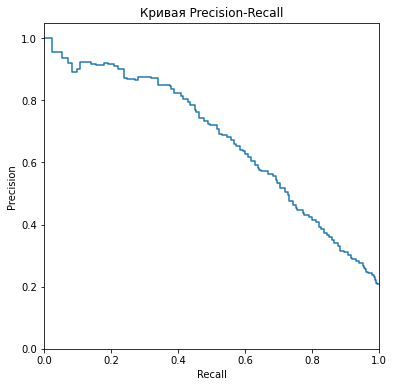

In [142]:
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Построим кривую ошибок. Чем выше она получается, тем выше качество модели. Прямая линия - это случайная модель.

In [143]:
precision, recall, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

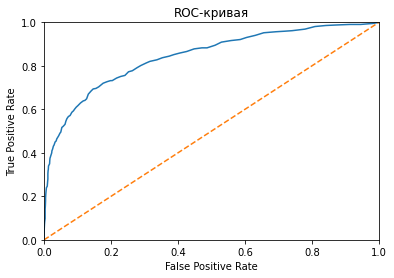

In [144]:
plt.figure()
plt.plot(precision, recall)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Посчитаем значение площади под кривой ошибок, чтобы оценить насколько наша модель отличается от случайной.

In [145]:
auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
auc_roc

0.8432273362408435

## Вывод

Наша задача заключалась в том, чтобы на основе исторических данных о поведении клиентов «Бета-банка» и расторжении договоров построить модель, которая будет прогнозировать, уйдет ли клиент из банка в ближайшее время или нет. Целевой значение F1-меры по условию было установлено на уровне 0.59. 
Для этого нам понадобилось подготовить предоставленные данные. Мы нашли и убрали пропуски, удалили стобцы, не несущие полезной информации. Обработали неистовые значения методом OHE и привели к одному масштабу оставшиеся числовые значения.

Мы рассмотрели три модели обучения. Самый высокий результат показала модель случайного леса - F1-мера равна 0.59.

Мы попробовали улучшить этот результат, убрав дисбаланс в данных, так как количество ответов 0 в данных было существенно выше 1.

Лучшего результата удалось добиться при уменьшении частых ответов техникой downsample. Мера F1 составила 0.617. Проверка на тестовых данных подтвердила качество модели, хотя значение F1 снизилось до 0.594, но осталось на целевом уровне.
